In [1]:
import cv2
import torch
import numpy as np
from glob import glob
from model import unet
from model import unet_att
import matplotlib.pyplot as plt
from utils.dataloader import PatchPathSet_2
from utils.imgShow import imgShow, imsShow
from utils.grad_cam import GradCAM
from utils.metrics import miou_binary

In [2]:
## load trained model
path_trained_unet = 'model/trained/patch_512/unet_weights.pth'
unet_model = unet(num_bands=7)
unet_model.load_state_dict(torch.load(path_trained_unet, weights_only=True))
unet_model.eval();  ##  


In [3]:
path_trained_unet_att = 'model/trained/patch_512/unet_att_weights_1.pth'
unet_att_model = unet_att(num_bands=7)
unet_att_model.load_state_dict(torch.load(path_trained_unet_att, weights_only=True))
unet_att_model.eval();  ##  


In [4]:
### data
### valset
paths_valset = sorted(glob(f'data/dset/valset/patch_512/*'))  ## for model prediction 
print(f'vali patch: {len(paths_valset)}')
val_data = PatchPathSet_2(paths_valset=paths_valset, 
                          patch_resize=None)


vali patch: 293


In [5]:
id_img = 80
img_rgb = val_data[id_img][0].numpy().transpose(1,2,0)[..., 0:3].astype(np.float32)[128:384, 128:384, :]
truth = val_data[id_img][1].numpy().transpose(1,2,0).astype(np.uint8)
img_rgb_low, img_rgb_high = np.percentile(img_rgb, 1), np.percentile(img_rgb, 92)
img_rgb = (img_rgb - img_rgb_low) / (img_rgb_high - img_rgb_low)  ## histogram stretching
img_rgb[img_rgb>1]=1
patch_4d = val_data[id_img][0].unsqueeze(0).float()
target_layer_unet = unet_model.outp[0]


In [ ]:
grad_cam_unet = GradCAM(unet_model, target_layer=target_layer_unet)
heatmap_unet, pred_unet = grad_cam_unet.forward(patch_4d) 
heatmap_unet = heatmap_unet[128:384, 128:384]
pred_unet = pred_unet[128:384, 128:384]
heatmap_2_unet = cv2.applyColorMap(np.uint8(255 * heatmap_unet), cv2.COLORMAP_JET)
heatmap_2_unet = heatmap_2_unet / 255.0 


In [7]:
pred_4d_unet = torch.from_numpy(pred_unet).unsqueeze(0).unsqueeze(0).float()
truth_4d = torch.from_numpy(truth).permute(2,0,1).unsqueeze(0).float()
miou_unet = miou_binary(pred=pred_4d_unet, truth=truth_4d)
print(miou_unet)

tensor(0.9201)


In [8]:
img_cam_unet = img_rgb*0.5 + heatmap_2_unet*0.5
# img_cam = np.where(heatmap_2 == 0, img_rgb, heatmap_2) 
  

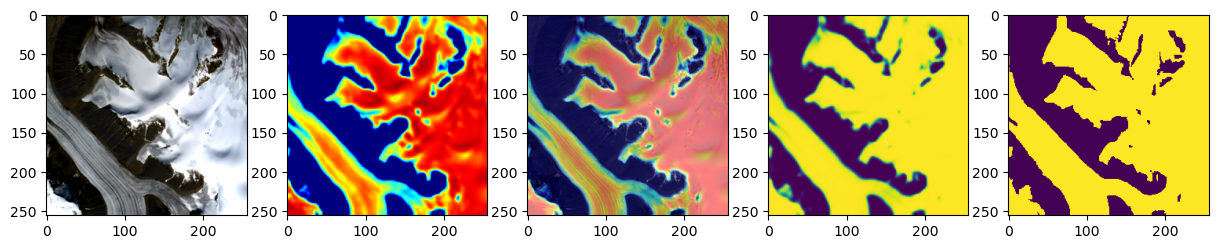

In [9]:
fig, ax = plt.subplots(1,5, figsize=(15,3))
imgShow(img_rgb, clip_percent=5, ax=ax[0])
imgShow(heatmap_2_unet, ax=ax[1], clip_percent=0)
imgShow(img_cam_unet, ax=ax[2], clip_percent=0)    
imgShow(pred_unet, ax=ax[3], clip_percent=0)    
ax[4].imshow(truth)     


### unet_attention spatial attention layer

In [10]:
target_layer_unet_att = unet_att_model.outp[0]
# target_layer_unet_att = unet_att_model.att_1.sa.conv
# target_layer_unet_att = unet_att_model.att_2.sa.conv


In [11]:
grad_cam_unet_att = GradCAM(unet_att_model, target_layer=target_layer_unet_att)
heatmap_unet_att, pred_unet_att = grad_cam_unet_att.forward(patch_4d)
heatmap_unet_att = cv2.resize(heatmap_unet_att, (512, 512))
heatmap_unet_att = heatmap_unet_att[128:384, 128:384]
pred_unet_att = pred_unet_att[128:384, 128:384]
heatmap_2_unet_att = cv2.applyColorMap(np.uint8(255 * heatmap_unet_att), cv2.COLORMAP_JET)
heatmap_2_unet_att = heatmap_2_unet_att / 255.0  
heatmap_2_unet_att.shape


(256, 256, 3)

In [12]:
pred_4d_unet_att = torch.from_numpy(pred_unet_att).unsqueeze(0).unsqueeze(0).float()
truth_4d = torch.from_numpy(truth).permute(2,0,1).unsqueeze(0).float()
miou_unet_att = miou_binary(pred=pred_4d_unet_att, truth=truth_4d)
print(miou_unet_att) 


tensor(0.9253)


In [13]:
img_cam_unet_att = img_rgb*0.5 + heatmap_2_unet_att*0.5


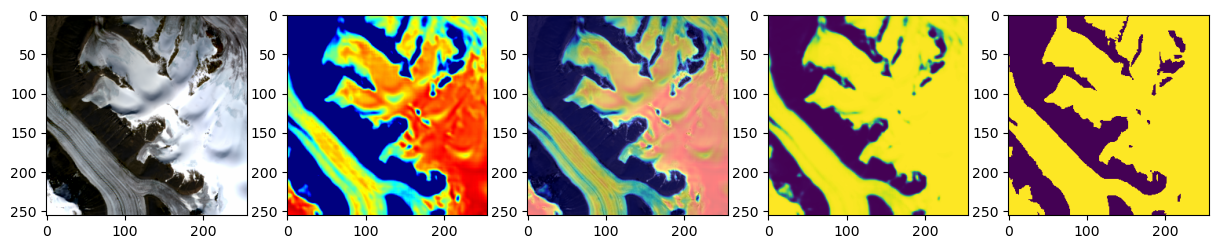

In [14]:
fig, ax = plt.subplots(1,5, figsize=(15,3))
imgShow(img_rgb, clip_percent=5, ax=ax[0])
imgShow(heatmap_2_unet_att, ax=ax[1], clip_percent=0)
imgShow(img_cam_unet_att, ax=ax[2], clip_percent=0)    
imgShow(pred_unet_att, ax=ax[3], clip_percent=0)    
ax[4].imshow(truth)     


Text(0.5, 1.0, 'Unet Att')

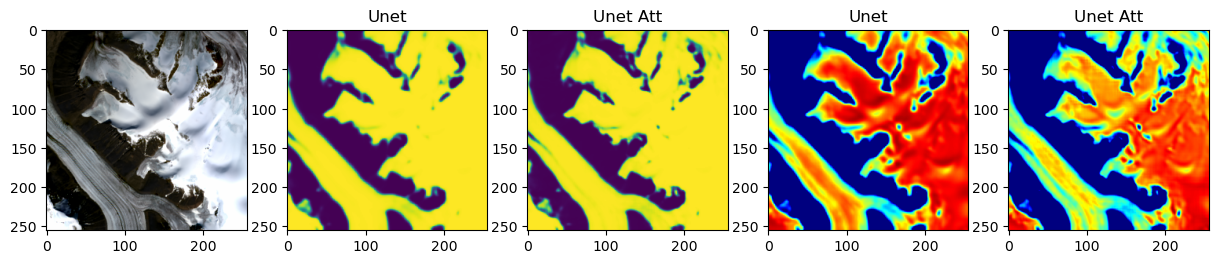

In [15]:
fig, ax = plt.subplots(1,5, figsize=(15,3))
imgShow(img_rgb, clip_percent=5, ax=ax[0])
imgShow(pred_unet, ax=ax[1], clip_percent=0); ax[1].set_title('Unet')
imgShow(pred_unet_att, ax=ax[2], clip_percent=0); ax[2].set_title('Unet Att')    
imgShow(heatmap_2_unet, ax=ax[3], clip_percent=0); ax[3].set_title('Unet')
imgShow(heatmap_2_unet_att, ax=ax[4], clip_percent=0); ax[4].set_title('Unet Att')

